## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
import csv
import matplotlib.cm as cm
import time
import math
from collections import Counter
from warnings import filterwarnings
filterwarnings(action='ignore')

random_seed = int(time.time())

## Loading Dataset

In [2]:
path = kagglehub.dataset_download("bhavikbb/password-strength-classifier-dataset")
csv_file = os.path.join(path, 'data.csv')

passwords = []
strengths = []

with open(csv_file, 'r', newline='', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader) 
    for row in csv_reader:
        if len(row) == 2:
            passwords.append(row[0])
            strengths.append(int(row[1]))

df = pd.DataFrame({'password': passwords, 'strength': strengths})
df = df.sample(n=10000, random_state=random_seed) # We chose 10k samples for reasonable compute time.

print(df.head())
print(df.shape)

          password  strength
361519    ade13340         1
238989     joana23         0
317387   2001maxim         1
393188  enuwyry981         1
200119   slmhmt501         1
(10000, 2)


## Description

In [3]:
print(df.describe(include='all'))

        password     strength
count      10000  10000.00000
unique     10000          NaN
top     ade13340          NaN
freq           1          NaN
mean         NaN      0.99310
std          NaN      0.50762
min          NaN      0.00000
25%          NaN      1.00000
50%          NaN      1.00000
75%          NaN      1.00000
max          NaN      2.00000


## Finding Null Values

In [4]:
print(df.isna().sum())

password    0
strength    0
dtype: int64


## Feature Engineering

In [5]:
def calculate_entropy(password):
    if not password:
        return 0
    counts = Counter(password)
    total_length = len(password)
    entropy = -sum((count / total_length) * math.log2(count / total_length) for count in counts.values())
    return entropy

def calculate_diversity(password):
    lower = sum(1 for c in password if c.islower())
    upper = sum(1 for c in password if c.isupper())
    digits = sum(1 for c in password if c.isdigit())
    specials = sum(1 for c in password if not c.isalnum())
    return lower, upper, digits, specials

def contains_sequential(password):
    for seq in ["secret", "abc", "qwe", "asd", "zxc", "123", "456", "789", "pass", "111", "222", "333", "444", "555", "666", "777", "888", "999"]:
        if seq in password.lower():
            return 1
    return 0

def calculate_length(password):
    return len(password)

# Apply feature engineering functions to the dataset
df['length'] = df['password'].apply(calculate_length)
df['entropy'] = df['password'].apply(calculate_entropy)
df['lowercase'], df['uppercase'], df['digits'], df['specials'] = zip(*df['password'].apply(calculate_diversity))
df['sequential'] = df['password'].apply(contains_sequential)

# New dataframe including the new features
print(df.head(10))

            password  strength  length   entropy  lowercase  uppercase  \
361519      ade13340         1       8  2.750000          3          0   
238989       joana23         0       7  2.521641          5          0   
317387     2001maxim         1       9  2.725481          5          0   
393188    enuwyry981         1      10  3.121928          7          0   
200119     slmhmt501         1       9  2.947703          6          0   
282279      palash20         1       8  2.750000          6          0   
38619   stevesidwe11         1      12  2.855389         10          0   
55285      matina017         1       9  2.947703          6          0   
456152       caixa10         0       7  2.521641          5          0   
466975      k8888037         1       8  2.000000          1          0   

        digits  specials  sequential  
361519       5         0           0  
238989       2         0           0  
317387       4         0           0  
393188       3         0     

## Data Analysis

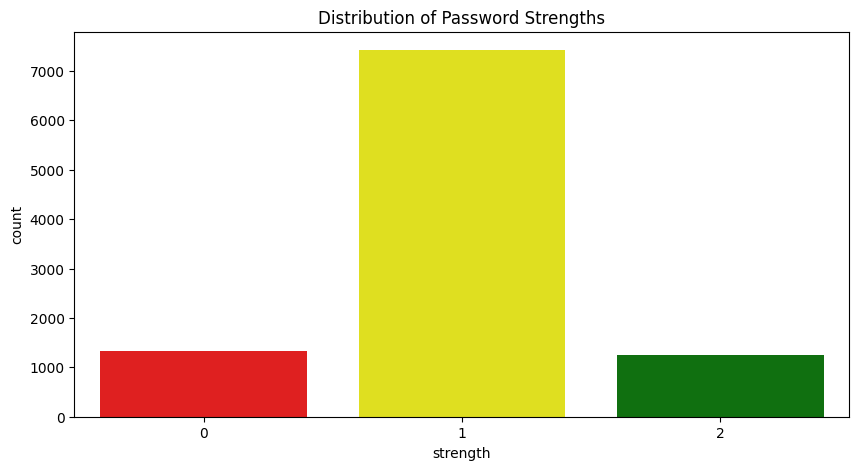

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(x='strength', data=df, palette={"0":"red", "1" :"yellow", "2": "green"})
plt.title('Distribution of Password Strengths')
plt.show()

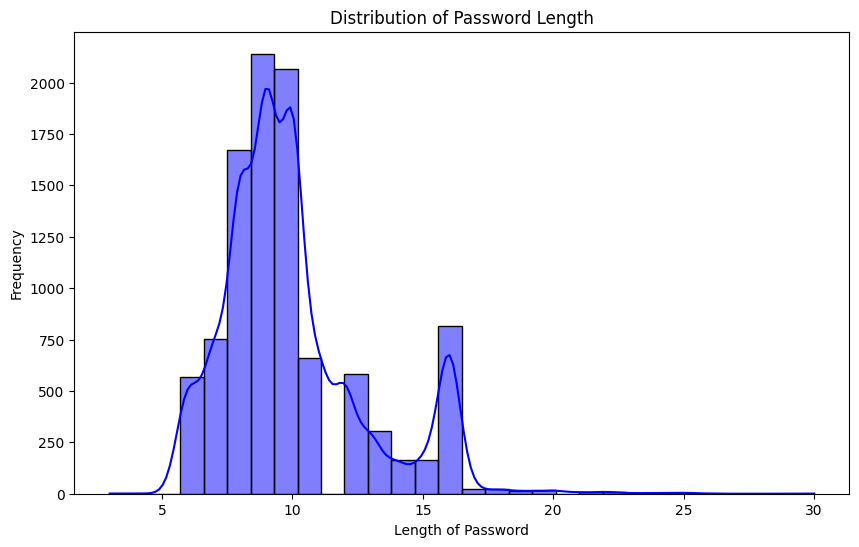

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Password Length')
plt.xlabel('Length of Password')
plt.ylabel('Frequency')
plt.show()

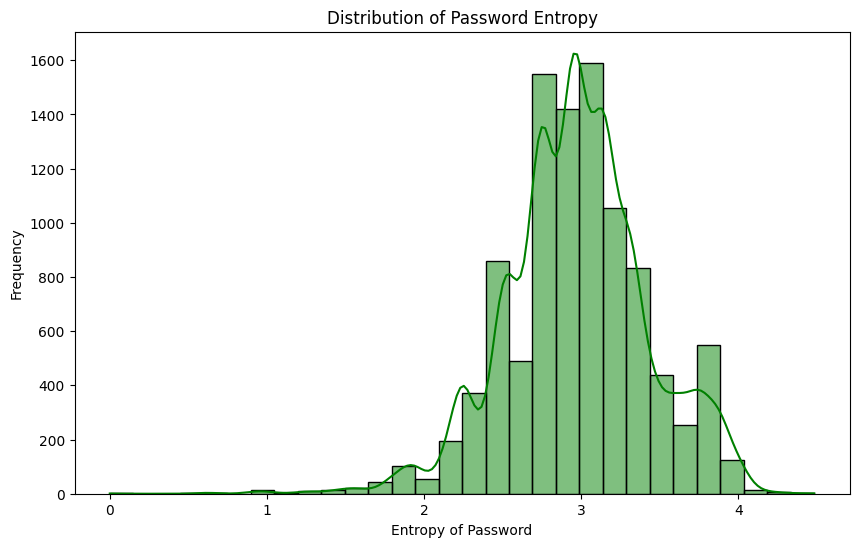

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['entropy'], bins=30, kde=True, color='green')
plt.title('Distribution of Password Entropy')
plt.xlabel('Entropy of Password')
plt.ylabel('Frequency')
plt.show()

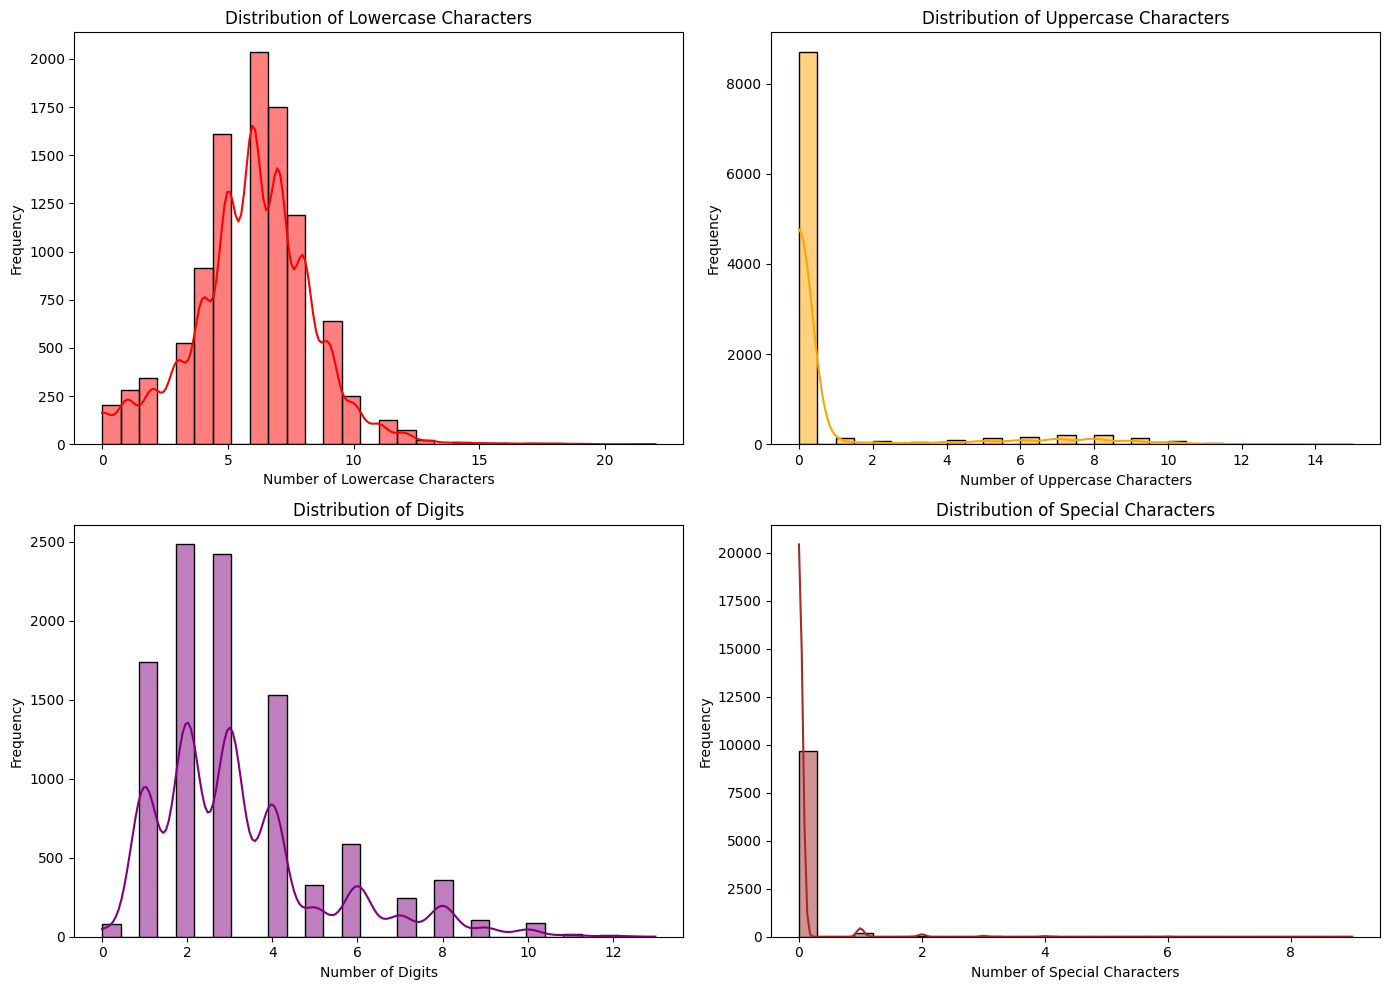

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Lowercase characters
sns.histplot(df['lowercase'], bins=30, kde=True, color='red', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Lowercase Characters')
axes[0, 0].set_xlabel('Number of Lowercase Characters')
axes[0, 0].set_ylabel('Frequency')

# Uppercase characters
sns.histplot(df['uppercase'], bins=30, kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Uppercase Characters')
axes[0, 1].set_xlabel('Number of Uppercase Characters')
axes[0, 1].set_ylabel('Frequency')

# Digits
sns.histplot(df['digits'], bins=30, kde=True, color='purple', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Digits')
axes[1, 0].set_xlabel('Number of Digits')
axes[1, 0].set_ylabel('Frequency')

# Specials
sns.histplot(df['specials'], bins=30, kde=True, color='brown', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Special Characters')
axes[1, 1].set_xlabel('Number of Special Characters')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

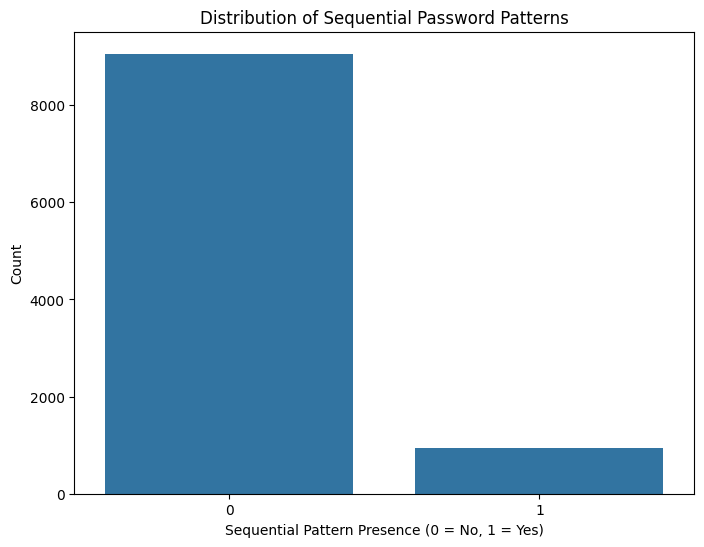

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df['sequential'])
plt.title('Distribution of Sequential Password Patterns')
plt.xlabel('Sequential Pattern Presence (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

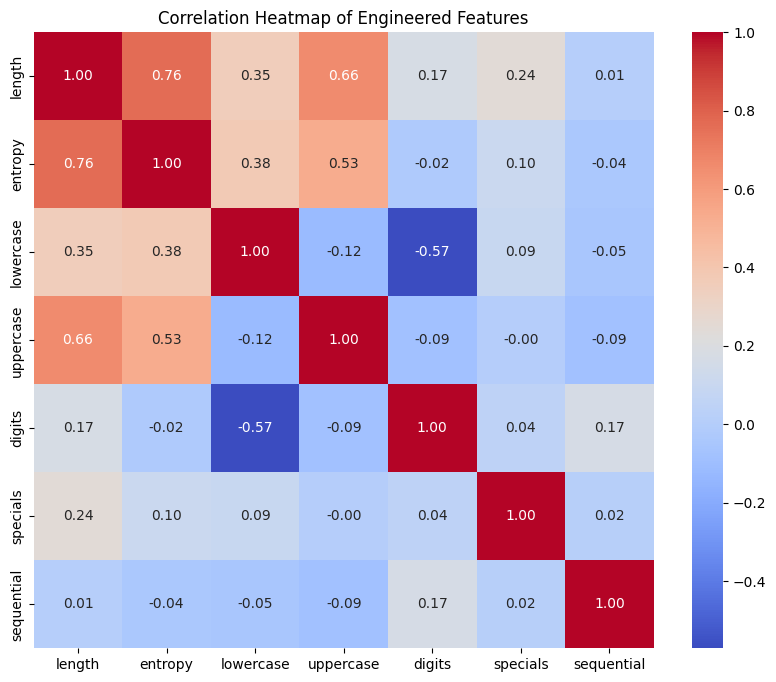

In [11]:
plt.figure(figsize=(10, 8))
corr = df[['length', 'entropy', 'lowercase', 'uppercase', 'digits', 'specials', 'sequential']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of Engineered Features')
plt.show()

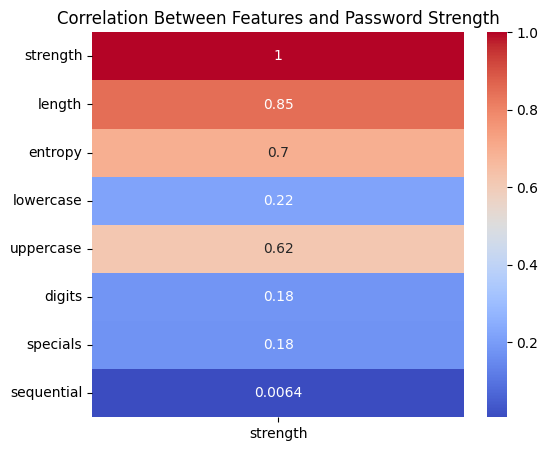

In [12]:
# Correlation Between Features and Password Strength
corr = df.corr(numeric_only=True)
plt.figure(figsize=(6,5))
sns.heatmap(corr[['strength']], annot=True, cmap='coolwarm')
plt.title('Correlation Between Features and Password Strength')
plt.show()

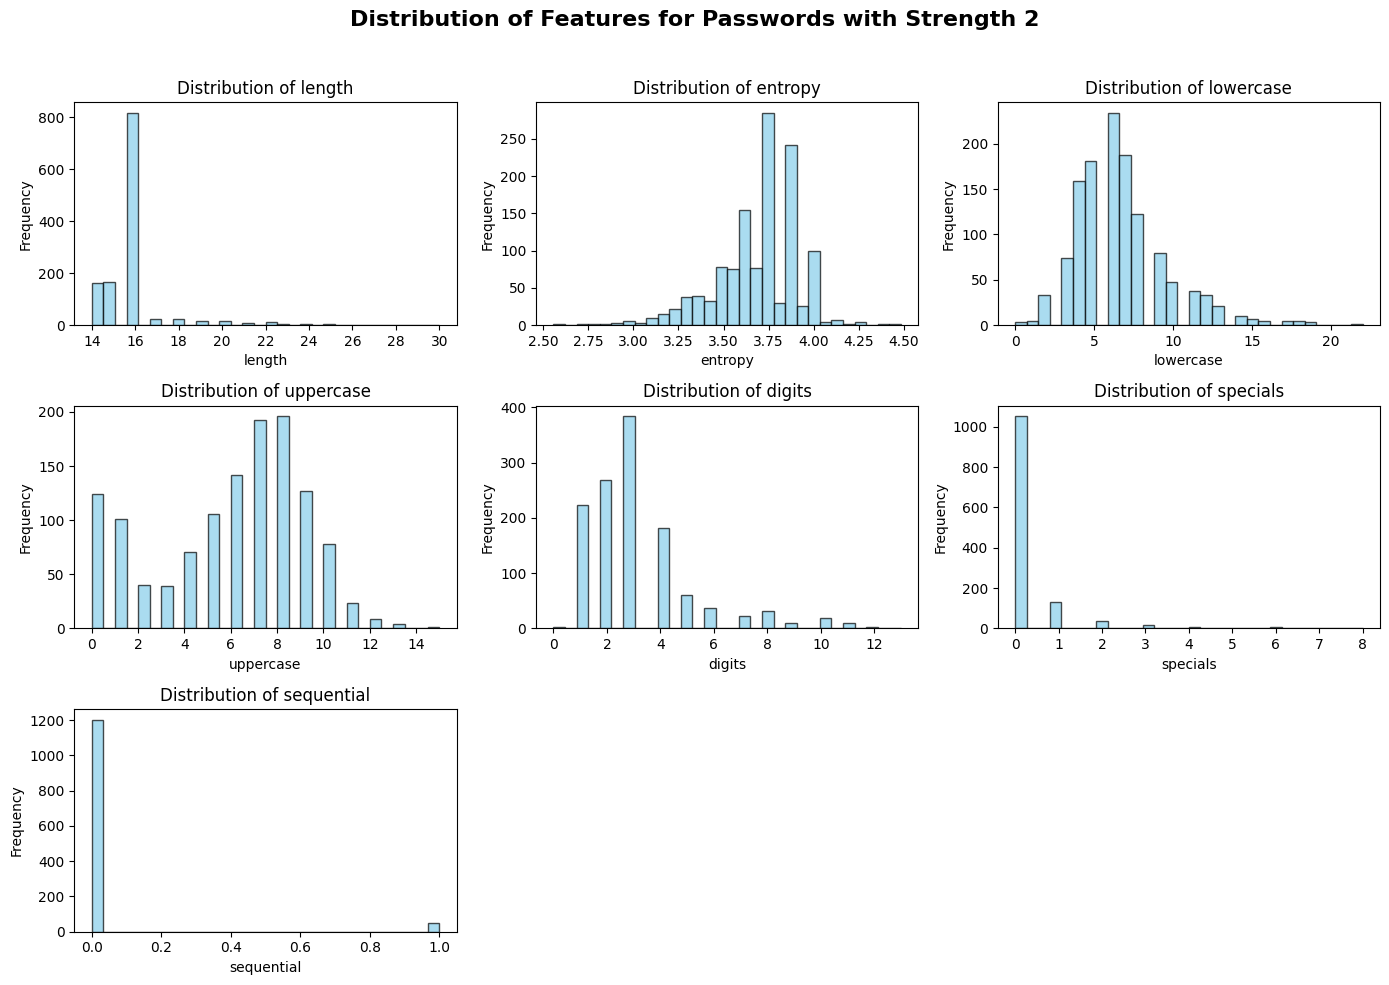

In [13]:
# Filter the dataset for passwords with strength "2"
df_strength_2 = df[df['strength'] == 2]
features = ['length', 'entropy', 'lowercase', 'uppercase', 'digits', 'specials', 'sequential']

plt.figure(figsize=(14, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    df_strength_2[feature].plot(kind='hist', bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.suptitle('Distribution of Features for Passwords with Strength 2', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

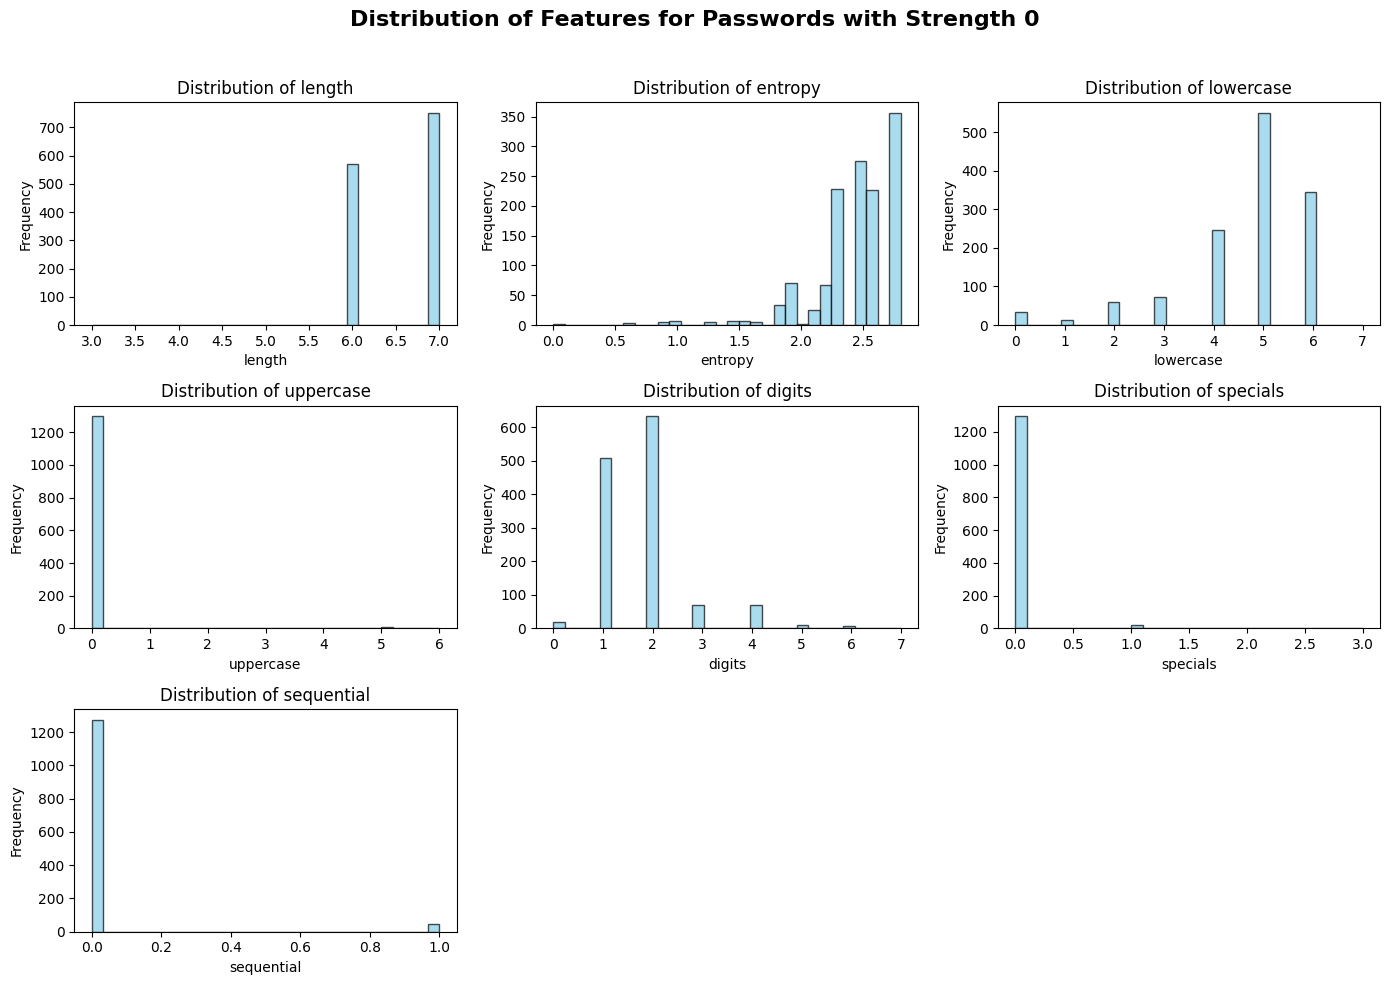

In [14]:
# Filter the dataset for passwords with strength "0"
df_strength_0 = df[df['strength'] == 0]
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    df_strength_0[feature].plot(kind='hist', bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.suptitle('Distribution of Features for Passwords with Strength 0', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Prepare the engineered features

In [15]:
X_engineered = df[['length','entropy', 'lowercase', 'uppercase', 'digits', 'specials', 'sequential']]
X_engineered_nl = df[['entropy', 'lowercase', 'uppercase', 'digits', 'specials', 'sequential']]
y = df['strength']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_engineered, y, test_size=0.3, random_state=random_seed, shuffle=True)
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X_engineered_nl, y, test_size=0.3, random_state=random_seed, shuffle=True)

## Model Training and Comparison using SVM, Logistic Regression, Random Forest, and KNN

In [16]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

models_to_evaluate = {
    "SVM": SVC(random_state=random_seed),
    "Logistic Regression": LogisticRegression(random_state=random_seed, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "KNN": KNeighborsClassifier()
}

results = {}

for model_name, model in models_to_evaluate.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results[model_name] = accuracy
    print(f"=== {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    print("\n" + "="*50 + "\n")

=== SVM ===
Accuracy: 0.9997
Confusion Matrix:
[[ 398    0    0]
 [   1 2243    0]
 [   0    0  358]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       398
           1       1.00      1.00      1.00      2244
           2       1.00      1.00      1.00       358

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



=== Logistic Regression ===
Accuracy: 0.9993
Confusion Matrix:
[[ 398    0    0]
 [   1 2242    1]
 [   0    0  358]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       398
           1       1.00      1.00      1.00      2244
           2       1.00      1.00      1.00       358

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00  

In [17]:
# Model Comparison Summary
print("Model Comparison Summary:")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")

Model Comparison Summary:
SVM: 0.9997
Logistic Regression: 0.9993
Random Forest: 1.0000
KNN: 0.9997


#### Additional Model Training for Feature Importance

In [18]:
# Random Forest Classifier for Feature Importance
rf_model = RandomForestClassifier(random_state=random_seed)
rf_model.fit(X_train, y_train)

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=random_seed)
dt_model.fit(X_train, y_train)

# Decision Tree Classifier (without 'length')
dt_model_nl = DecisionTreeClassifier(random_state=random_seed)
dt_model_nl.fit(X_train_nl, y_train_nl)

DecisionTreeClassifier(random_state=1740301293)

## Feature Importance Visualization

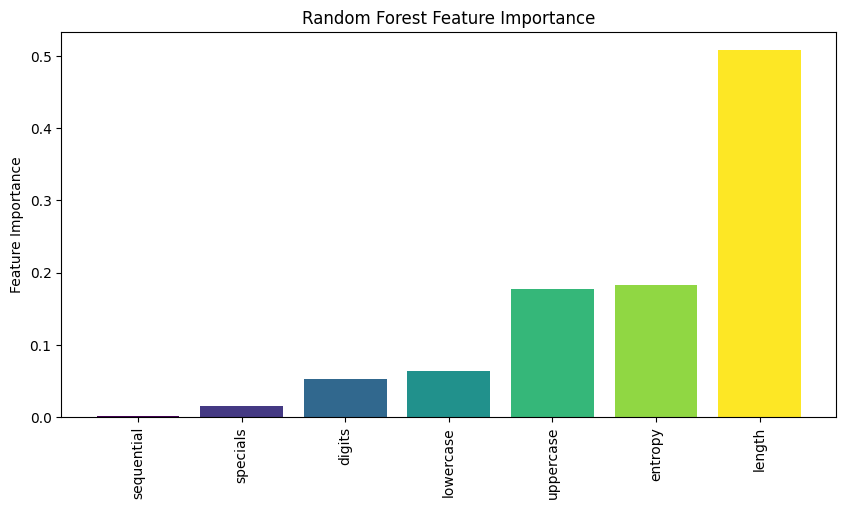

In [19]:
# Random Forest Feature Importance
rf_importances = rf_model.feature_importances_
features_list = X_engineered.columns
sorted_indices = np.argsort(rf_importances)[::-1]

sorted_features = np.array(features_list)[sorted_indices]
sorted_importances = rf_importances[sorted_indices]

colors = cm.viridis(np.linspace(0, 1, len(sorted_importances)))

plt.figure(figsize=(10, 5))
plt.bar(sorted_features[::-1], sorted_importances[::-1], color=colors)
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=90)
plt.show()

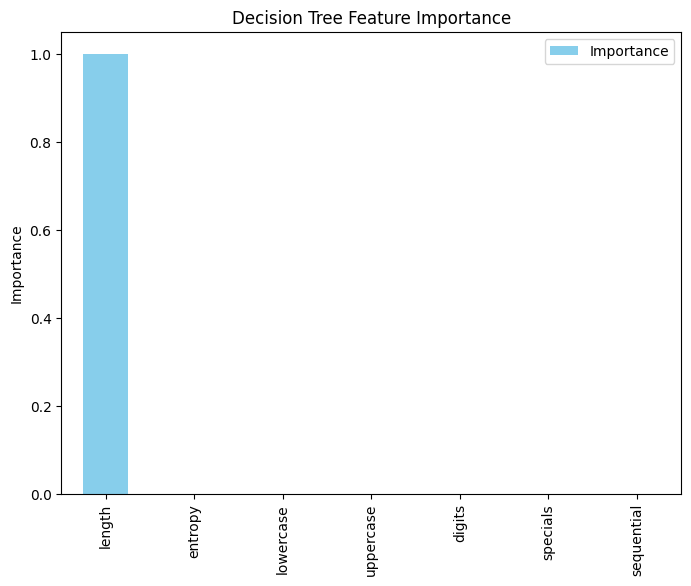

In [20]:
# Decision Tree Feature Importance
feat_importances = pd.DataFrame(dt_model.feature_importances_, index=X_engineered.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8, 6), color='skyblue')
plt.title('Decision Tree Feature Importance')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

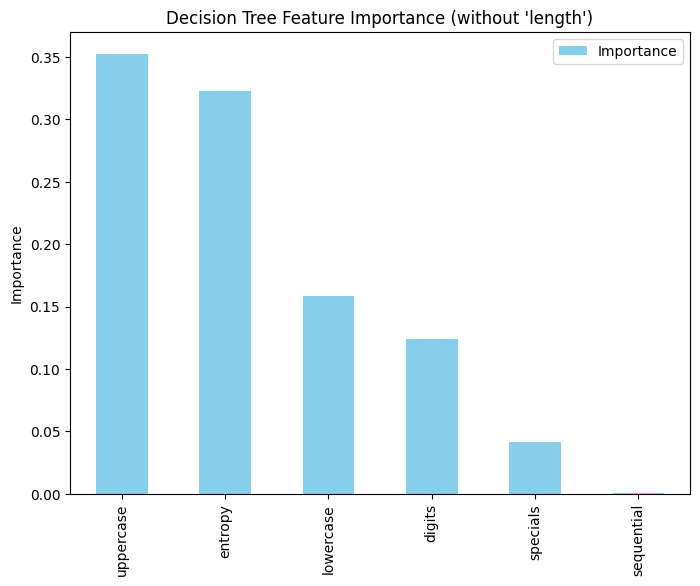

In [21]:
# Decision Tree Feature Importance without 'length'
feat_importances_nl = pd.DataFrame(dt_model_nl.feature_importances_, index=X_engineered_nl.columns, columns=["Importance"])
feat_importances_nl.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances_nl.plot(kind='bar', figsize=(8, 6), color='skyblue')
plt.title("Decision Tree Feature Importance (without 'length')")
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

#### Feature Importance for Passwords Classified as "strong"

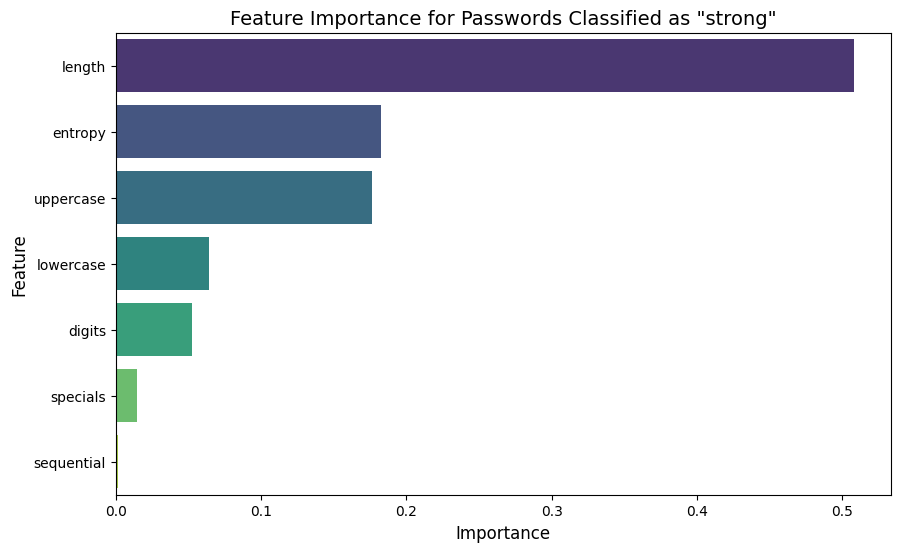

In [22]:
X_class_2 = X_train[y_train == 2]
feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_class_2.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Passwords Classified as "strong"', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

#### We can derive from this graph that 'length', 'uppercase' and 'entropy' are the most important features to a password 